<a href="https://colab.research.google.com/github/nosadchiy/public/blob/main/CaLNG_demand_with_option.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [5]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install seaborn
import seaborn as sns
# control the figure size
plt.rcParams["figure.figsize"] = (20,3)
#!pip install matplotlib
import time


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.0 MB/s eta 0:00:00a 0:00:01


In [6]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [9]:
# inspect demand data
demand_data

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123
...,...,...,...
86,February,25,52
87,February,26,39
88,February,27,109
89,February,28,250


In [12]:
# inspect intake price data
intake_price_data

,Intake,Price
0,20,1.000000
1,24,1.000000
2,31,1.000000
3,34,1.000000
4,37,1.000000
...,...,...
86,263,7.266926
87,263,7.266926
88,263,7.266926
89,292,11.783104


# Decision Variables

In [19]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

In [20]:
 math.exp(max(0, (263 - 144)/60))

7.2669257439848165

# Utility (Actual Usage)

In [21]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [22]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,123,123,181,1.85,1257.85,3117.30
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,41,41,181,1.85,642.85,171.74
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,69,69,181,1.85,852.85,609.98


In [23]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [24]:
calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, 1288)

CaLNG price: $7.50
---
Peak intake from pipeline: 181 MMcf
Total peak months intake from pipeline: 12,428 MMcf
Total intake from CaLNG: 1,288 MMcf
---
Total amount paid to pipeline: $18,463,575
Total amount paid to CaLNG: $9,660,000
Total cost for utility: $28,123,575
Savings from using CaLNG: $12,080,986
---
Total cost if average draw daily: $15,342,871


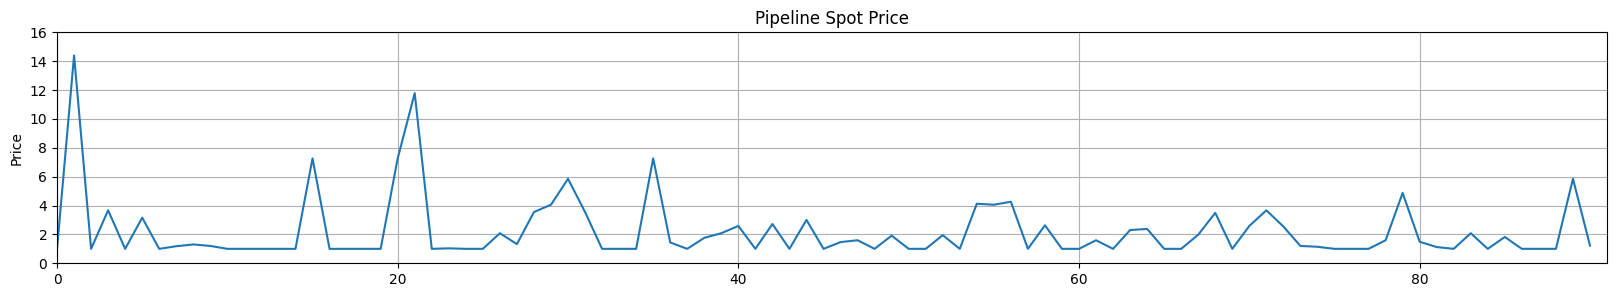

In [25]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_price')
plt.title('Pipeline Spot Price')
plt.axis([0, 91, 0, 16])
plt.grid()
plt.xlabel("")
plt.ylabel("Price")
plt.show()

# Demand

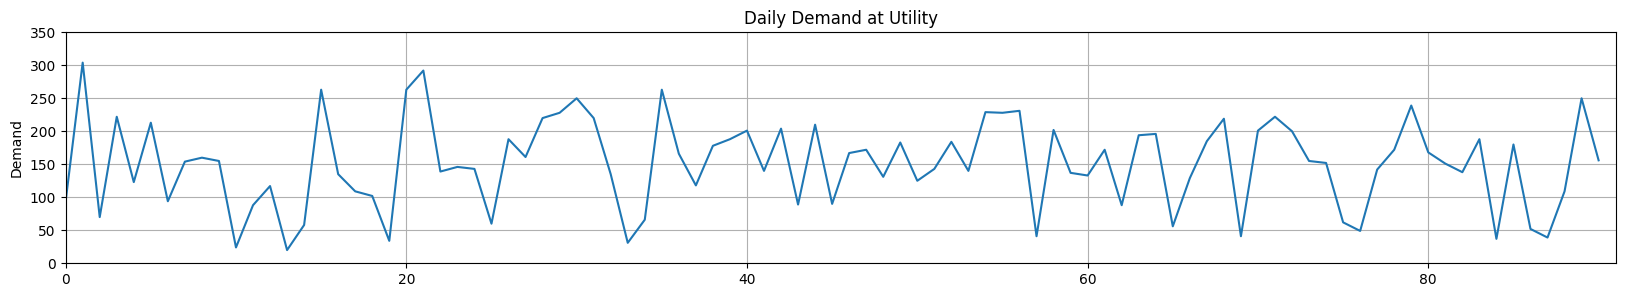

In [26]:
sns.lineplot(data=usage_data, x='price_index', y='Demand')
plt.title('Daily Demand at Utility')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# Intake from Pipeline

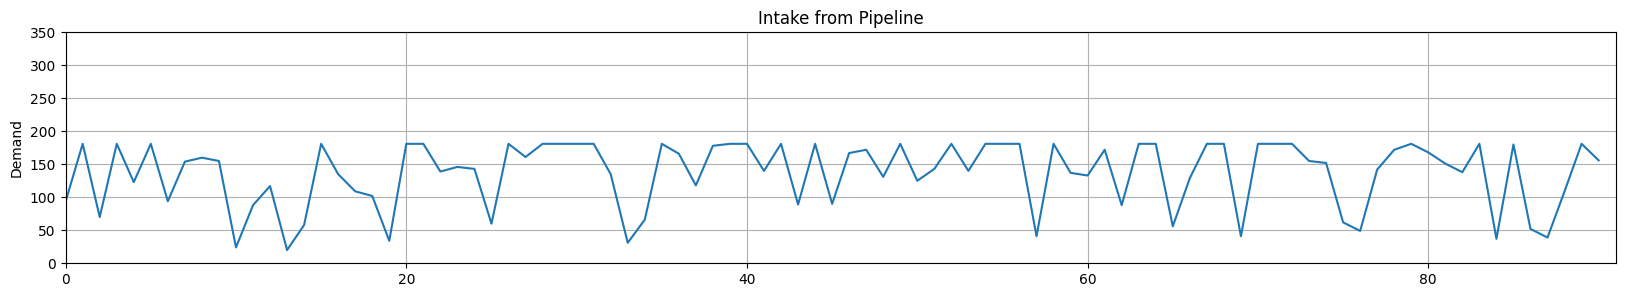

In [27]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_intake')
plt.title('Intake from Pipeline')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# CaLNG Purchase

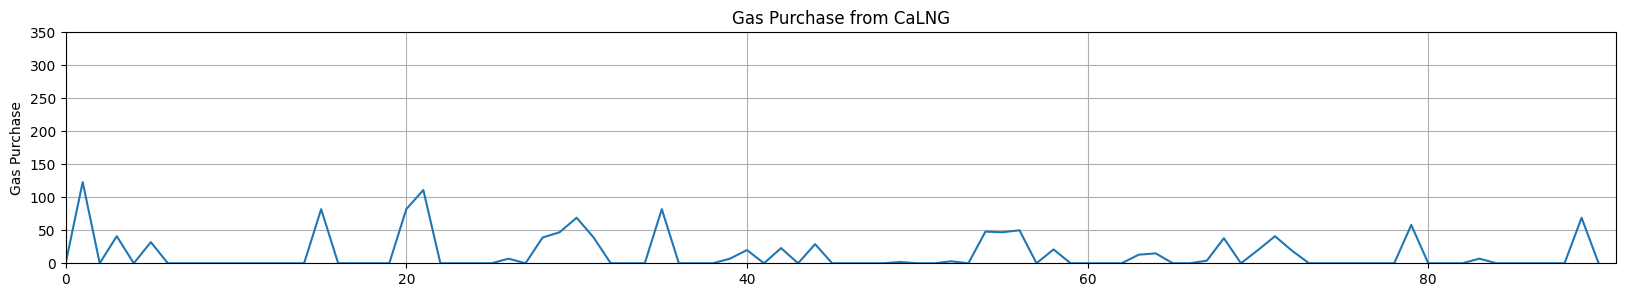

In [28]:
sns.lineplot(data=usage_data, x='price_index', y='purchase_from_calng')
plt.title('Gas Purchase from CaLNG')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Gas Purchase")
plt.show()

# Intake vs. Spot Price

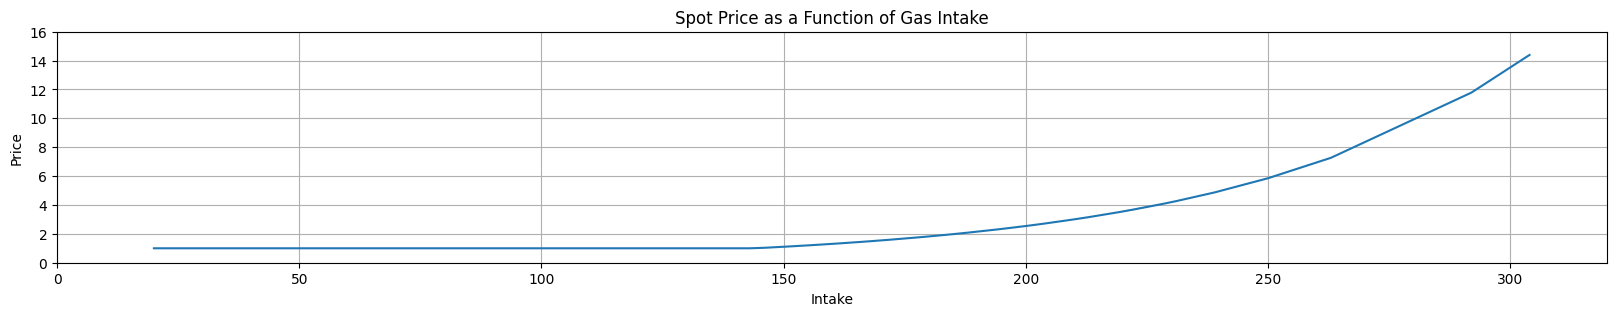

In [29]:
sns.lineplot(data=intake_price_data, x='Intake', y='Price')
plt.title('Spot Price as a Function of Gas Intake')
plt.axis([0, 320, 0, 16])
plt.grid()
plt.show()

In [39]:
demand_data['Demand'].mean()

150.72527472527472

In [40]:
demand_data['Demand'].std()

67.11963877767751

# Option

In [30]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

In [31]:
# simulate demand data
sim_demand_data = demand_data.copy()

# generate sample
demand_sample = np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data))
demand_sample = np.round(np.where(demand_sample < 0, 0, demand_sample),0)

sim_demand_data['Demand'] = demand_sample
sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake_from_pipeline, total_lng)

calculate_cost_statistics(sim_usage_data, calng_price, peak_intake_from_pipeline, total_lng)

CaLNG price: $7.50
---
Peak intake from pipeline: 180 MMcf
Total peak months intake from pipeline: 12,417 MMcf
Total intake from CaLNG: 905 MMcf
---
Total amount paid to pipeline: $17,365,268
Total amount paid to CaLNG: $9,000,000
Total cost for utility: $26,365,268
Savings from using CaLNG: $5,010,110
---
Total cost if average draw daily: $13,864,665


In [60]:
df

,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily
0,170.0,700.0,12425.6464,698.3868,2.175023e+07,5250000.0,2.700023e+07,4.487690e+06,1.376061e+07
1,175.0,700.0,12423.0136,693.7400,2.102928e+07,5250000.0,2.627928e+07,5.224949e+06,1.373993e+07
2,180.0,700.0,12453.6484,682.3128,2.063094e+07,5250000.0,2.588094e+07,5.968687e+06,1.379057e+07
3,185.0,700.0,12466.1566,654.7004,2.011942e+07,5250000.0,2.536942e+07,6.525787e+06,1.374975e+07
4,190.0,700.0,12500.4432,610.0714,1.994679e+07,5250000.0,2.519679e+07,6.914398e+06,1.371276e+07
...,...,...,...,...,...,...,...,...,...
67,175.0,1250.0,12115.4800,999.9064,1.653309e+07,9375000.0,2.590809e+07,7.465590e+06,1.373694e+07
68,180.0,1250.0,12230.0342,882.5154,1.719850e+07,9375000.0,2.657350e+07,7.630152e+06,1.373655e+07
69,185.0,1250.0,12349.1620,773.0506,1.804822e+07,9375000.0,2.742322e+07,7.728842e+06,1.372730e+07
70,190.0,1250.0,12435.7736,668.5204,1.890839e+07,9375000.0,2.828339e+07,7.605278e+06,1.370229e+07


# Option Optimization
In progress

In [34]:
# number of simulation draws per scenario

num_draws = 5000
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range= range(170,200,5)

cost_stat_list = []

for total in total_lng_range:
    for peak in peak_intake_from_pipeline_range:
        sims = []
        for n in range(num_draws):
            # simulate demand data
            sim_demand_data = demand_data.copy()

            # generate sample
            demand_sample = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data)))
            demand_sample = np.where(demand_sample < 0, 0, demand_sample)

            sim_demand_data['Demand'] = demand_sample

            # get simulated usage data
            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak, total)
            cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak, total, return_data=True)


            sims.append(cost_stat_dict)


        cost_stat_list.append(np.mean(pd.DataFrame(sims), axis=0))

df = pd.DataFrame(cost_stat_list)



In [66]:

start_time = time.time()

calng_price = 7.50

# mean_daily_demand = demand_data['Demand'].mean()  # Example mean daily demand
# std_dev_daily_demand = demand_data['Demand'].std()  # Example standard deviation of daily demand

# Simulation parameters
mean_daily_demand = 144
std_dev_daily_demand = 59
num_draws = 5000
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range= range(170,200,5)

# Data structure to store simulation results
results = []

optimal_cost = float('inf')
optimal_parameters = None

for total_lng in total_lng_range:
    for peak_intake in peak_intake_from_pipeline_range:
        costs_for_scenario = []
        
        for _ in range(num_draws):

            sim_demand_data = demand_data.copy()

            # generate sample
            demand_sample = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data)))
            demand_sample = np.where(demand_sample < 0, 0, demand_sample)

            sim_demand_data['Demand'] = demand_sample
            
            # Determine actual usage and calculate cost statistics
            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake, total_lng)
            cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak_intake, total_lng, return_data=True)
            
            costs_for_scenario.append(cost_stat_dict['total_utility_cost'])
        
        average_cost_for_scenario = np.mean(costs_for_scenario)
        std_dev_cost_for_scenario = np.std(costs_for_scenario)
        
        # Store results
        results.append({
            'total_lng': total_lng,
            'peak_intake': peak_intake,
            'average_cost': average_cost_for_scenario,
            'std_dev_cost': std_dev_cost_for_scenario
        })
        
        if average_cost_for_scenario < optimal_cost:
            optimal_cost = average_cost_for_scenario
            optimal_parameters = (total_lng, peak_intake)

# Convert results to DataFrame for easier analysis and plotting
results_df = pd.DataFrame(results)

# Output the optimal parameters
print(f"Optimal total_LNG: {optimal_parameters[0]}, Optimal peak_intake_from_pipeline: {optimal_parameters[1]}, with average cost: {optimal_cost}")

# Proceed with plotting the results as needed
# Proceed with plotting the results as needed
end_time = time.time()

# Calculate the total runtime
total_time = end_time - start_time

print(f"Time taken to run the code: {total_time} seconds")

Optimal total_LNG: 900, Optimal peak_intake_from_pipeline: 180, with average cost: 25119438.051569954
Time taken to run the code: 8990.440795898438 seconds


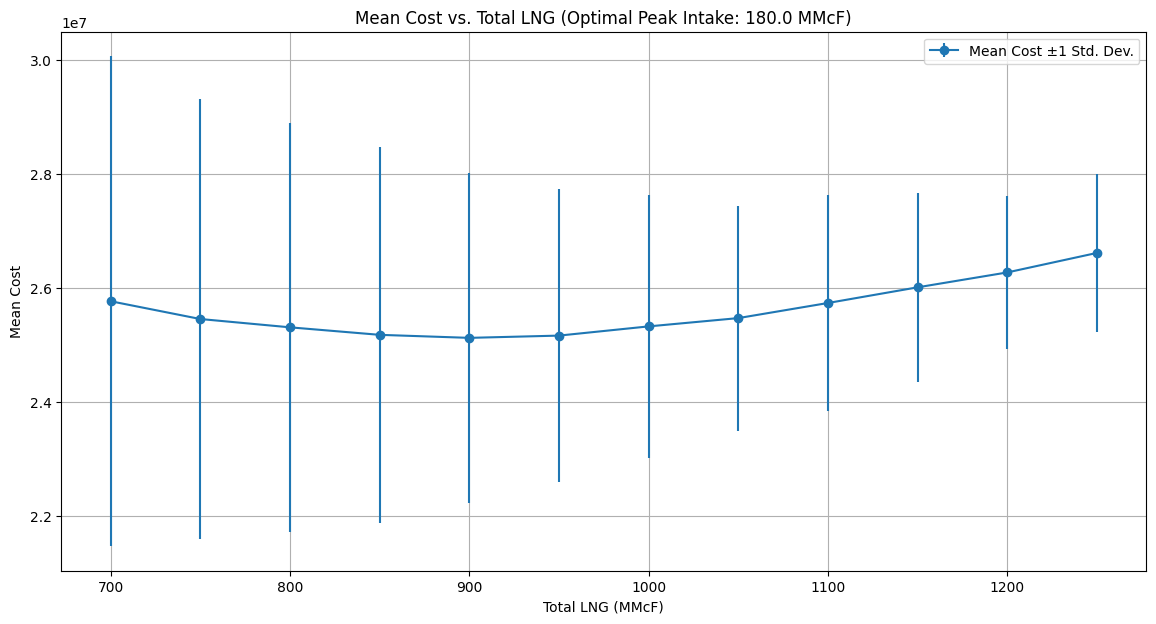

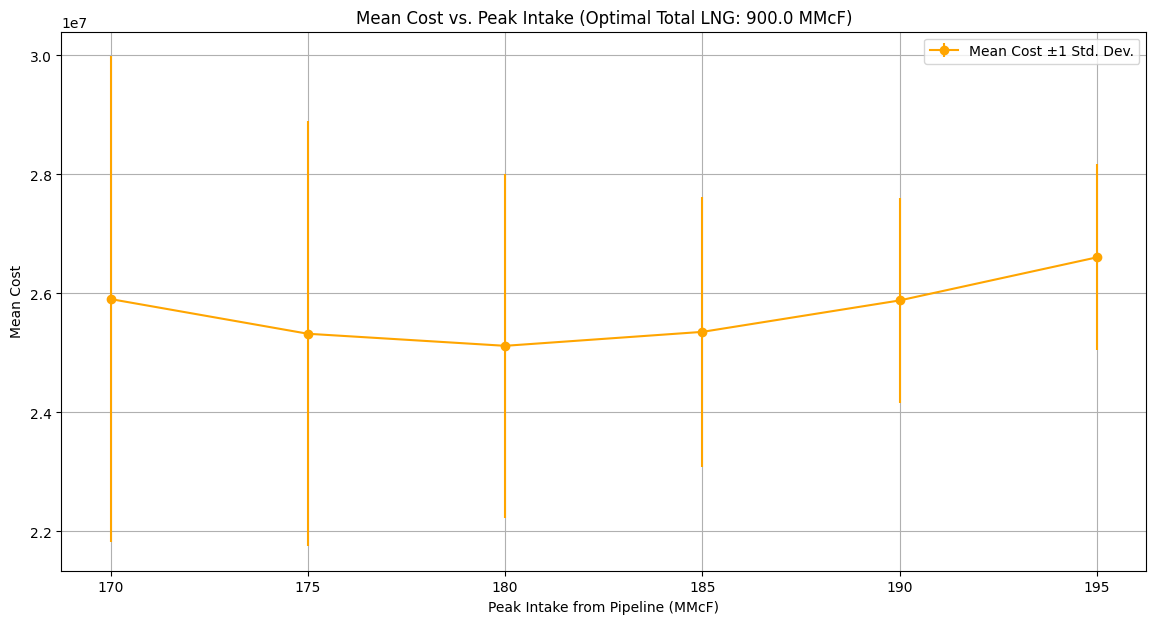

In [67]:

optimal = results_df.loc[results_df['average_cost'].idxmin()]
optimal_total_lng = optimal['total_lng']
optimal_peak_intake = optimal['peak_intake']
# Data for plotting Total LNG vs. Cost for the optimal peak intake
data_for_total_lng = results_df[results_df['peak_intake'] == optimal_peak_intake]

# Data for plotting Peak Intake vs. Cost for the optimal total LNG
data_for_peak_intake = results_df[results_df['total_lng'] == optimal_total_lng]
import matplotlib.pyplot as plt

# Plot 1: Total LNG vs. Cost for the optimal peak intake
plt.figure(figsize=(14, 7))
plt.errorbar(data_for_total_lng['total_lng'], data_for_total_lng['average_cost'], 
             yerr=data_for_total_lng['std_dev_cost'], fmt='-o', label='Mean Cost ±1 Std. Dev.')
plt.xlabel('Total LNG (MMcF)')
plt.ylabel('Mean Cost')
plt.title(f'Mean Cost vs. Total LNG (Optimal Peak Intake: {optimal_peak_intake} MMcF)')
plt.legend()
plt.grid(True)

# Plot 2: Peak Intake vs. Cost for the optimal total LNG
plt.figure(figsize=(14, 7))
plt.errorbar(data_for_peak_intake['peak_intake'], data_for_peak_intake['average_cost'], 
             yerr=data_for_peak_intake['std_dev_cost'], fmt='-o', color='orange', label='Mean Cost ±1 Std. Dev.')
plt.xlabel('Peak Intake from Pipeline (MMcF)')
plt.ylabel('Mean Cost')
plt.title(f'Mean Cost vs. Peak Intake (Optimal Total LNG: {optimal_total_lng} MMcF)')
plt.legend()
plt.grid(True)

plt.show()
